## Parsing : Document to CSV

In [ ]:
import os
import csv
from PyPDF2 import PdfReader

INPUT_DIR = 'papers_adhd'
OUTPUT_DIR = 'papers_adhd_csvs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

output_csv = os.path.join(OUTPUT_DIR, 'all_papers.csv')

with open(output_csv, mode='w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(
        csvfile,
        quoting=csv.QUOTE_MINIMAL,    # only quote fields when needed
        quotechar='"',                # wrap fields containing special chars in "
        escapechar='\\'               # escape embedded quotechars with backslash
    )
    writer.writerow(['page_text', 'source_file', 'page_number'])

    for fname in os.listdir(INPUT_DIR):
        if not fname.lower().endswith('.pdf'):
            continue

        pdf_path = os.path.join(INPUT_DIR, fname)
        try:
            reader = PdfReader(pdf_path)
        except Exception as e:
            print(f'[!] Could not open "{fname}": {e}')
            continue

        for page_num, page in enumerate(reader.pages, start=1):
            try:
                text = page.extract_text() or ''
            except Exception as e:
                text = f'[Error on page {page_num}: {e}]'

            # remove any null bytes that can break the CSV writer
            text = text.replace('\x00', '')

            writer.writerow([text, fname, page_num])

        print(f'  → Processed "{fname}" ({len(reader.pages)} pages)')

print(f'All done! Combined CSV written to:\n  {output_csv}')


## Understanding Data

In [1]:
import pandas as pd

# df= pd.read_csv(r"papers_adhd_csvs/all_papers.csv", encoding='utf-8', escapechar='\\')
# df['page_text'] = df['page_text'].str.replace(r'\\', '', regex=True)

df= pd.read_csv(r"papers_adhd_csvs/all_papers.csv", encoding='utf-8')

print(f'Number of rows: {len(df)}')
print(f'Number of columns: {len(df.columns)}')
print(f'Columns: {df.columns.tolist()}')

print(f'First 5 rows:\n{df.head()}')

max_length = df['page_text'].str.len().max()
print(f'Max length of page_text: {max_length}')

max_length = df['page_text'].str.len().mean()
print(f'Mean length of page_text: {max_length}')

Number of rows: 280
Number of columns: 3
Columns: ['page_text', 'source_file', 'page_number']
First 5 rows:
                                           page_text source_file  page_number
0  Exploring N-Back Cognitive Training for Childr...  paper1.pdf            1
1  prevalence of ADHD, the chances are high that ...  paper1.pdf            2
2  these interventions, teachers (behavioral clas...  paper1.pdf            3
3  inhibition and working memory-demanding execut...  paper1.pdf            4
4  learning or attention disorders. Based on our ...  paper1.pdf            5
Max length of page_text: 10525
Mean length of page_text: 3987.3107142857143


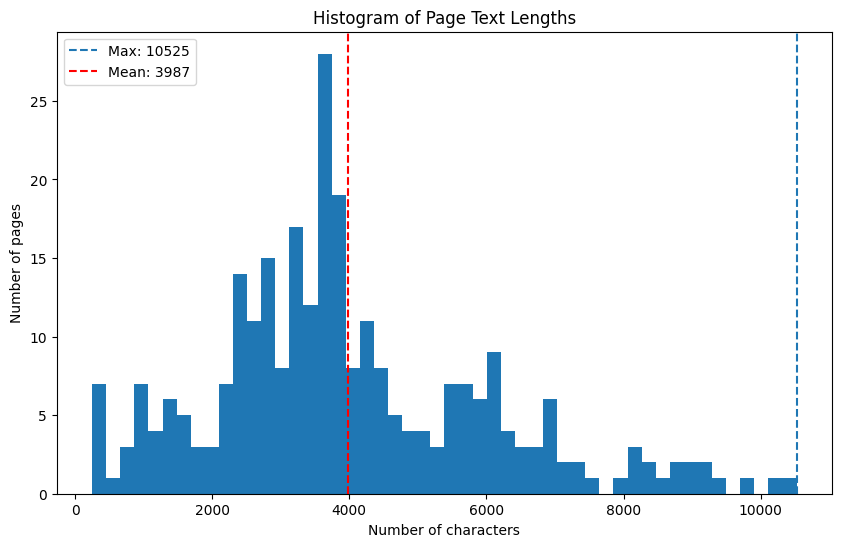

Max length of page_text: 10525
Mean length of page_text: 3987.31


In [3]:
# Histogram of page_text lengths
import matplotlib.pyplot as plt
# Compute the length of each page's text
lengths = df['page_text'].astype(str).str.len()

# Plot a histogram of those lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50)
plt.title('Histogram of Page Text Lengths')
plt.xlabel('Number of characters')
plt.ylabel('Number of pages')

# Mark the max and mean
max_len = lengths.max()
mean_len = lengths.mean()
plt.axvline(max_len, linestyle='--',  label=f'Max: {max_len:.0f}')
plt.axvline(mean_len, linestyle='--',color='r', label=f'Mean: {mean_len:.0f}')
plt.legend()

plt.show()

# Print out the numeric stats
print(f'Max length of page_text: {max_len}')
print(f'Mean length of page_text: {mean_len:.2f}')







## Chunking

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from semchunk import chunkerify
from tqdm import tqdm
import numpy as np
import json

# === CONFIGURATION ===
INPUT_CSV = 'papers_adhd_csvs/all_papers.csv'
OUTPUT_CSV = 'papers_adhd_csvs/all_papers_chunked_embeddings.csv'

TOKENIZER_MODEL = "medicalai/ClinicalBERT"
CHUNK_SIZE = 256
TOKEN_THRESHOLD = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === LOAD DATA ===
df = pd.read_csv(INPUT_CSV, encoding='utf-8')
df['page_text'] = df['page_text'].astype(str)

# === INITIALIZE TOKENIZER, MODEL, CHUNKER ===
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
model = AutoModel.from_pretrained(TOKENIZER_MODEL).to(DEVICE)
model.eval()

chunker = chunkerify(tokenizer, CHUNK_SIZE)

# === EMBEDDING FUNCTION (CLS token approach) ===
@torch.no_grad()
def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=TOKEN_THRESHOLD).to(DEVICE)
    outputs = model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
    return cls_embedding.squeeze().cpu().numpy()

# === MAIN PROCESSING LOOP ===
chunked_rows = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    text = row['page_text']
    token_ids = tokenizer.encode(text, add_special_tokens=False)

    if len(token_ids) > TOKEN_THRESHOLD:
        chunks = chunker(text)
    else:
        chunks = [text]

    for c in chunks:
        token_len = len(tokenizer.encode(c, add_special_tokens=False))
        if token_len <= TOKEN_THRESHOLD:
            embedding = get_embedding(c)
            chunked_rows.append({
                'chunk': c,
                'source_file': row.get('source_file', ''),
                'page_number': row.get('page_number', None),
                'token_length': token_len,
                'embedding': embedding.tolist()  # Convert NumPy array to list for JSON serialization
            })
        else:
            print(f"⚠️ Skipped chunk over limit ({token_len} tokens)")


chunked_df = pd.DataFrame(chunked_rows)
chunked_df.to_csv(OUTPUT_CSV, index=False, encoding='utf-8')

print(f"✅ Chunked data with embeddings saved to: {OUTPUT_CSV}")

100%|██████████| 280/280 [02:04<00:00,  2.26it/s]


✅ Chunked data with embeddings saved to: papers_adhd_csvs/all_papers_chunked_embeddings.csv


=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   chunk         1313 non-null   object
 1   source_file   1313 non-null   object
 2   page_number   1313 non-null   int64 
 3   token_length  1313 non-null   int64 
 4   embedding     1313 non-null   object
dtypes: int64(2), object(3)
memory usage: 51.4+ KB
None

=== Sample Rows ===
                                               chunk source_file  page_number  \
0  Exploring N-Back Cognitive Training for Childr...  paper1.pdf            1   
1  Inhibition; attention; working memory training...  paper1.pdf            1   
2  2002 ; Faraone, Biederman, & Mick, 2005 ; Matt...  paper1.pdf            1   
3  prevalence of ADHD, the chances are high that ...  paper1.pdf            2   
4  tasks, including the Wisconsin Card Sorting Te...  paper1.pdf            2   

   token_leng

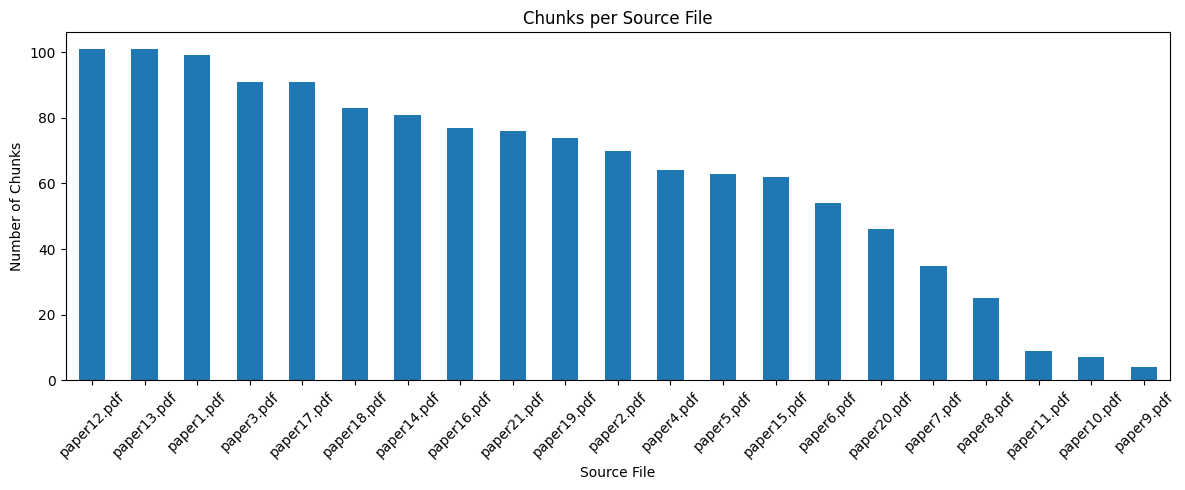

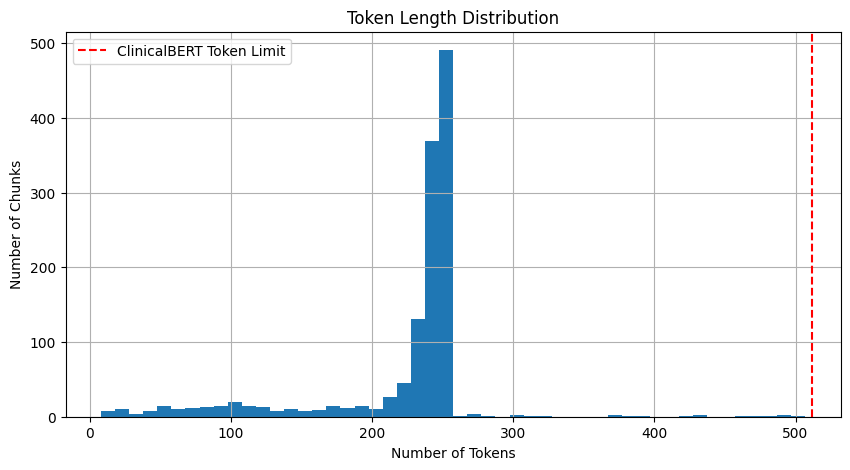

Embedding Matrix Shape: (1313, 768)


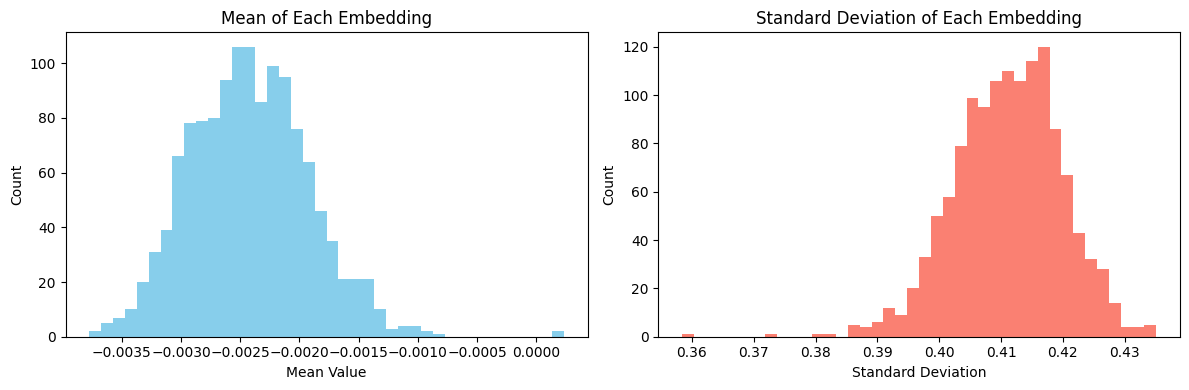

Running t-SNE... (this may take a moment)


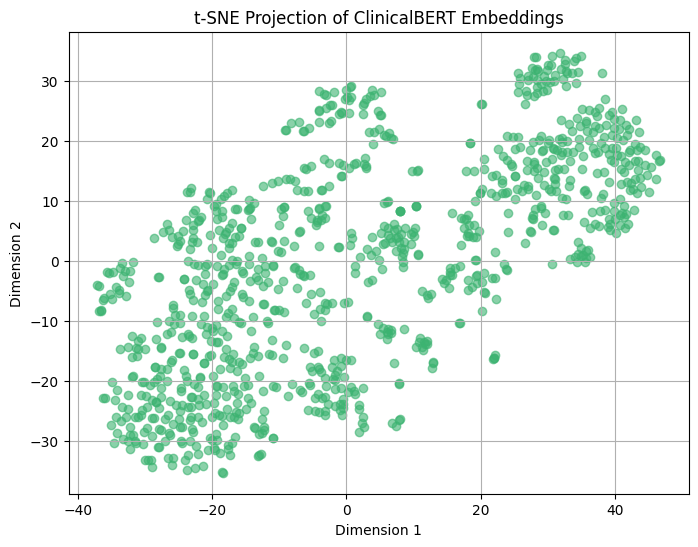

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.manifold import TSNE

# === Load the CSV with ClinicalBERT embeddings ===
csv_path = 'papers_adhd_csvs/all_papers_chunked_embeddings.csv'
df = pd.read_csv(csv_path)

# === Convert stringified embeddings back to lists ===
df['embedding'] = df['embedding'].apply(ast.literal_eval)

# === Display structure and sample data ===
print("=== DataFrame Info ===")
print(df.info())
print("\n=== Sample Rows ===")
print(df.head())

# === Chunks per Document ===
if 'source_file' in df.columns:
    plt.figure(figsize=(12, 5))
    df['source_file'].value_counts().plot(kind='bar')
    plt.title('Chunks per Source File')
    plt.xlabel('Source File')
    plt.ylabel('Number of Chunks')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# === Token Length Distribution ===
plt.figure(figsize=(10, 5))
df['token_length'].hist(bins=50)
plt.axvline(512, color='red', linestyle='--', label='ClinicalBERT Token Limit')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Chunks')
plt.legend()
plt.grid(True)
plt.show()

# === Convert Embeddings to NumPy Matrix ===
embedding_matrix = np.array(df['embedding'].tolist())
print("Embedding Matrix Shape:", embedding_matrix.shape)

# === Embedding Mean and Std Histograms ===
embedding_means = embedding_matrix.mean(axis=1)
embedding_stds = embedding_matrix.std(axis=1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(embedding_means, bins=40, color='skyblue')
plt.title('Mean of Each Embedding')
plt.xlabel('Mean Value')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(embedding_stds, bins=40, color='salmon')
plt.title('Standard Deviation of Each Embedding')
plt.xlabel('Standard Deviation')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# === t-SNE Visualization (on subset for performance) ===
print("Running t-SNE... (this may take a moment)")
subset_size = min(1000, len(embedding_matrix))  # cap at 1000 for speed
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_proj = tsne.fit_transform(embedding_matrix[:subset_size])

plt.figure(figsize=(8, 6))
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], alpha=0.6, c='mediumseagreen')
plt.title("t-SNE Projection of ClinicalBERT Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()